## EDA and linear regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Подготовка данных

Будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. 

Скачаем обучающую выборку.

In [3]:
train = pd.read_csv('train.csv')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Организаторы соревнования добавили колонку dropoff_datetime только в обучающую выборку, удалим ее. Также для удобства переведем объекты из колонки pickup_datetime в datetime-объекты. 

In [4]:
#Удалим колонку dropoff_datetime
train.drop('dropoff_datetime', axis=1, inplace=True)

In [5]:
#преобразуем даты в datetime-объекты
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. 

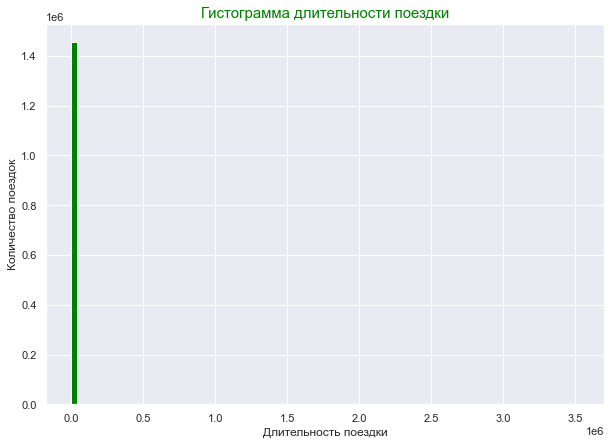

In [6]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.hist(train['trip_duration'].values, bins=100,color="green")
plt.title('Гистограмма длительности поездки', color = 'green', fontsize = 15)
plt.xlabel('Длительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Сведем задачу оптимизации RMSLE к задаче оптимизации MSE. Прологорифмируем целевую переменную, удалим колонку со старым таргетом.

In [7]:
#Добабили колонку к выборке
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

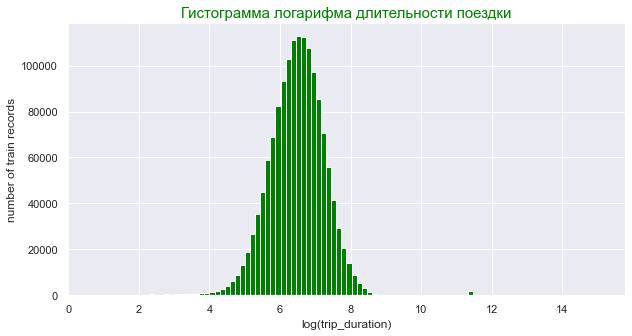

In [8]:
#Нарисуем гистограмму модифицированного таргета по обучающей выборке
plt.rcParams['figure.figsize'] = [10, 5]
plt.hist(train['log_trip_duration'].values, bins=100, color="green")
plt.title('Гистограмма логарифма длительности поездки', fontsize = 15, color = 'green')
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [9]:
#Удалим колонку со старым таргетом
#train.drop('trip_duration', axis=1, inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
#Константное предсказание - среднее
from sklearn import metrics
mse_const_mean = metrics.mean_squared_error(np.mean(train['log_trip_duration']) * np.ones(train.shape[0]), train['log_trip_duration'])
print(np.sqrt(mse_const_mean))

0.7957592365411504


In [11]:
#Константное предсказание - медиана (в данной задаче вполне логично взять за константу медиану, саме частое время в пути)
from sklearn import metrics
mse_const_median = metrics.mean_squared_error(np.median(train['log_trip_duration']) * np.ones(train.shape[0]), train['log_trip_duration'])
print(np.sqrt(mse_const_median))

0.7963168959485897


## Анализ признаков. Изучаем `pickup_datetime` 

Посмотрим, сколько всего было поездок в каждый из дней. 

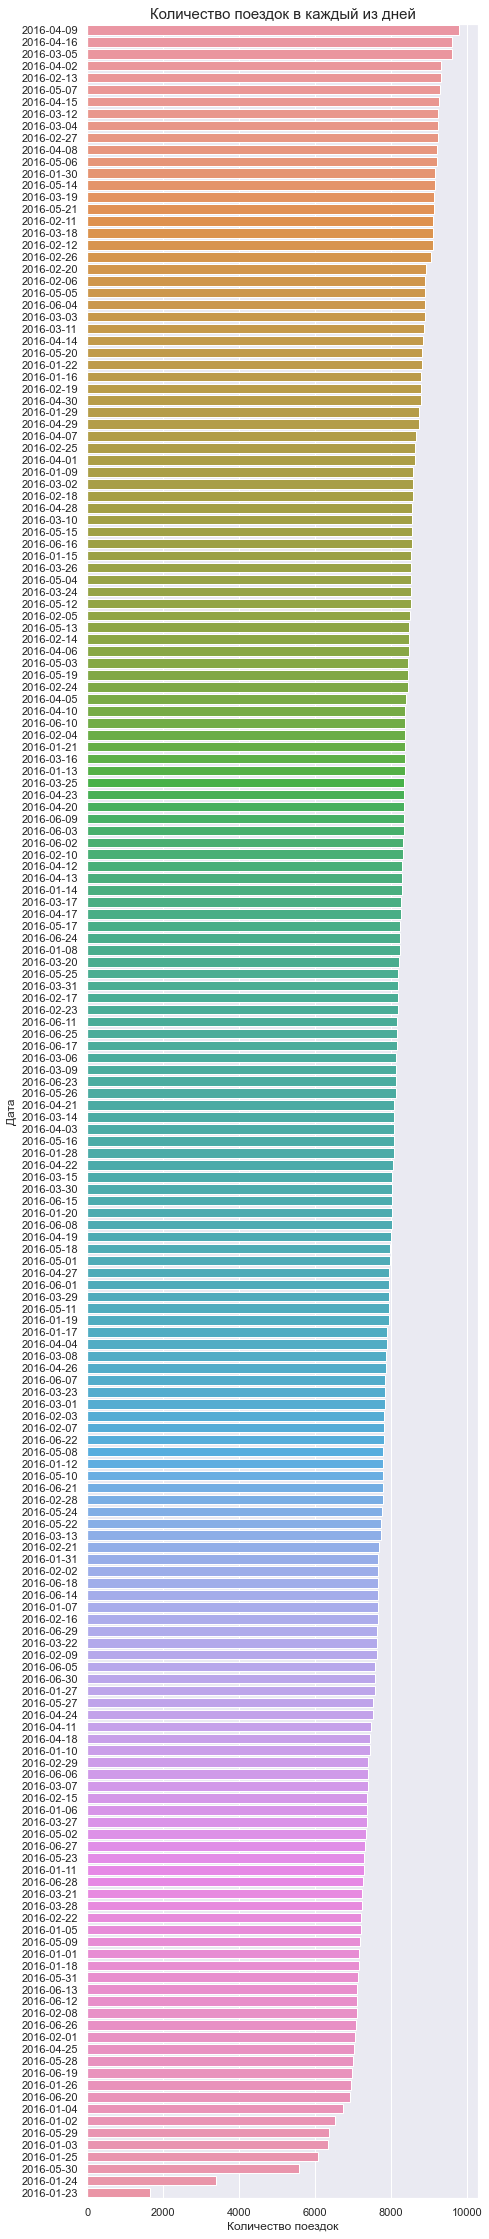

In [12]:
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = [7, 40]

dates = train['pickup_datetime'].dt.date
chart = sns.countplot(y = dates, data = train, order = dates.value_counts().index)

plt.title('Количество поездок в каждый из дней', fontsize = 15)
plt.xlabel('Количество поездок')
plt.ylabel('Дата')

plt.show()

**<span style="color:green">Видим, что на графике есть 2 периода, когда количесвто поездок было аномально низким : 23 и 24 января 2016 года. В эти даты в Нью-Йорке была сильнейшая снежная буря и власти запретили передвигаться по улицам на автомобилях, для предотвращения аварийно-опасных ситуаций </span>**

**Построим первый график зависимости**

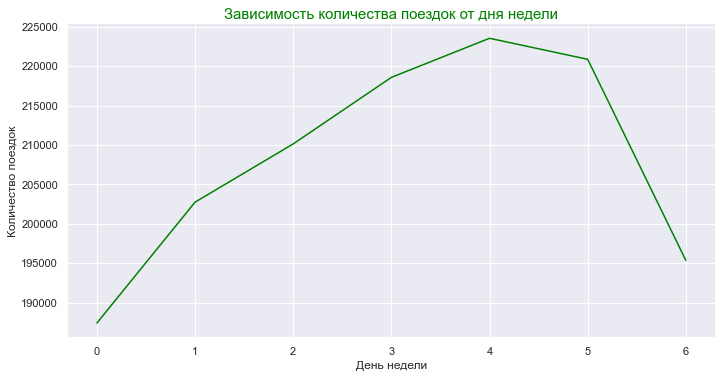

In [13]:
#Понедельник = 0, вторник = 1, ... , воскресенье = 6.
day_of_week = train.groupby(train['pickup_datetime'].dt.weekday)['id'].count()

sns.relplot(data = pd.DataFrame(day_of_week), y='id', x='pickup_datetime', kind='line', height=5, aspect=2, color='green')

plt.title('Зависимость количества поездок от дня недели', color='green', fontsize = 15)
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.show()

**Построим второй график зависимости**

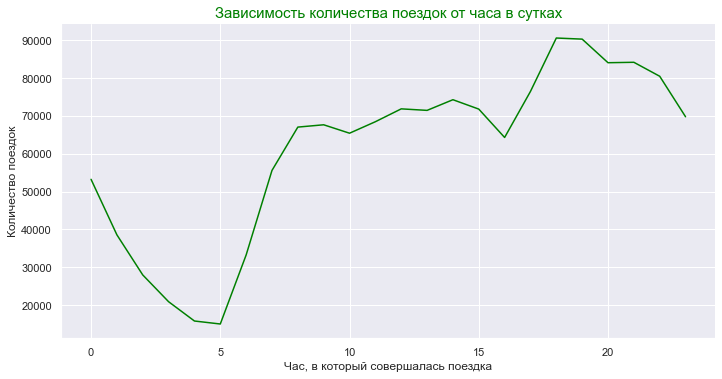

In [14]:
day_of_week = train.groupby(train['pickup_datetime'].dt.hour)['id'].count()

sns.relplot(data = pd.DataFrame(day_of_week), y='id', x='pickup_datetime', kind='line', height=5, aspect=2, color='green')

plt.title('Зависимость количества поездок от часа в сутках', color='green', fontsize = 15)
plt.xlabel('Час, в который совершалась поездка')
plt.ylabel('Количество поездок')
plt.show()

**Нарисуем зависимости количества поездок от часа в сутках для разных месяцев**

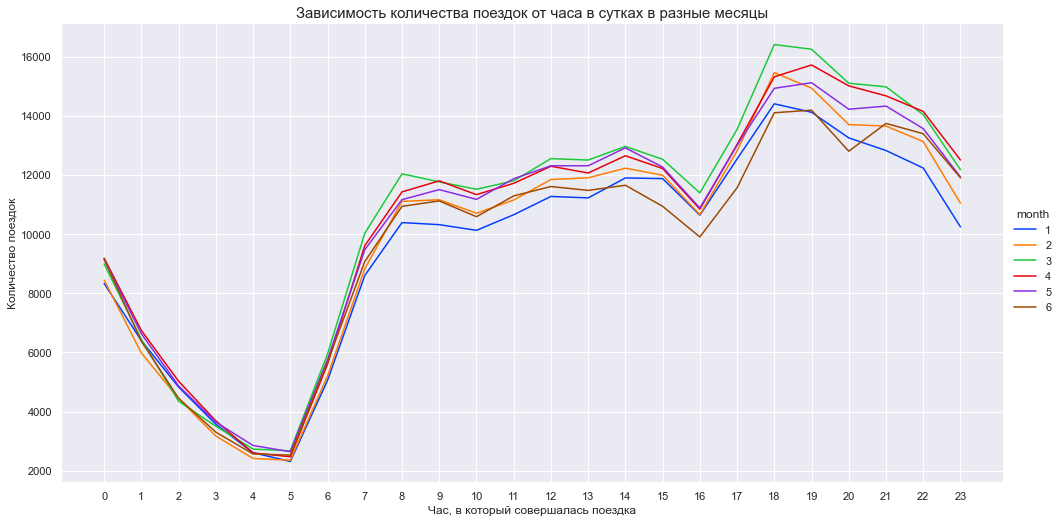

In [15]:
#The month as January=1, December=12.
months_hours = pd.DataFrame(train.groupby([train['pickup_datetime'].dt.month, train['pickup_datetime'].dt.hour])['id'].count())
months_hours.index = months_hours.index.rename(['month', 'hours'])

months_hours.reset_index(inplace=True)

sns.relplot(data=months_hours, y='id', x='hours', kind='line', hue='month', height=7, aspect=2, palette="bright")
plt.xticks(range(24))


plt.title('Зависимость количества поездок от часа в сутках в разные месяцы', fontsize = 15)
plt.xlabel('Час, в который совершалась поездка')
plt.ylabel('Количество поездок')
plt.show()

**Нарисуем зависимости количества поездок от часа в сутках для разных дней недели**

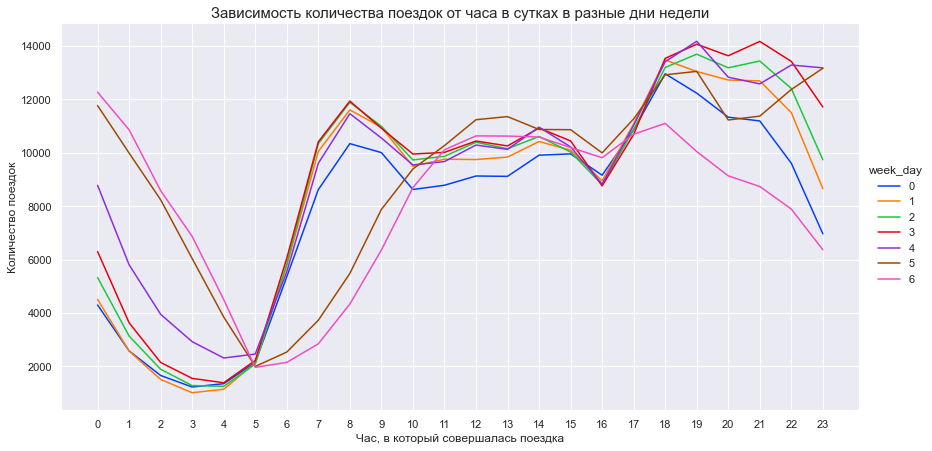

In [16]:
#Понедельник = 0, вторник = 1, ... , воскресенье = 6.
months_hours = pd.DataFrame(train.groupby([train['pickup_datetime'].dt.weekday,train['pickup_datetime'].dt.hour])['id'].count())
months_hours.index = months_hours.index.rename(['week_day', 'hours'])

months_hours.reset_index(inplace=True)

sns.relplot(data=months_hours, y='id', x='hours', kind='line', hue='week_day', height=6, aspect=2, palette="bright")
plt.xticks(range(24))


plt.title('Зависимость количества поездок от часа в сутках в разные дни недели', fontsize = 15)
plt.xlabel('Час, в который совершалась поездка')
plt.ylabel('Количество поездок')
plt.show()

**<span style="color:green">Дни недели:</span>** <span style="color:green">на графике "Зависимость количества поездок от часа в сутках в разные дни недели" можно заметить, что субботу и воскресенье отличаются от остальных дней. Видим, что совершалось намного меньше поездок с 6 до 9 утра, кажется, это связано с тем, что люди не торопились на выходных на работу. Также видим, что в понедельник поездок как-то поменьше, чем в другие дни, возможно это связано с тем, что неделя только началась и люди еще не погрузились в работу, поэтому не ездили на встречи. Также можно увидеть, что в четверг (красная линия) поездок было больше, чем в остальные дни, особенно в вечернее время.</span>
    
**<span style="color:green"> Месяца:</span>** <span style="color:green"> Выделился март (зеленый цвет), люди совершали больше поездок в этот месяц возможно из-за праздника, а возможно потому что пришла весна, и стало теплее (захотелось поехать погулять).</span>
    
**<span style="color:green">Время суток:</span>** <span style="color:green">Видим, что меньше всего поездок люди совершали с 1 до 5 утра, так как скорее всего спали. Затем с 6 до 8 утра количество поездок сильно возрастает, так как люди торопились на работу. Потом 9 до 16 часов количество поездок слабо колебалось, так как люди работали и пользовались такси не очень активно. Но после 17 часов спрос на поездки на такси резко возрастает, так как люди торопились домой с работы. И к вечеру спрос соответственно снижался.</span>

**Разобьем исходную выборку на обучающую и тестовую в отношении 7:3**

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_4, test = train_test_split(train, test_size = 0.3, random_state = 1)

**По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от дня недели**

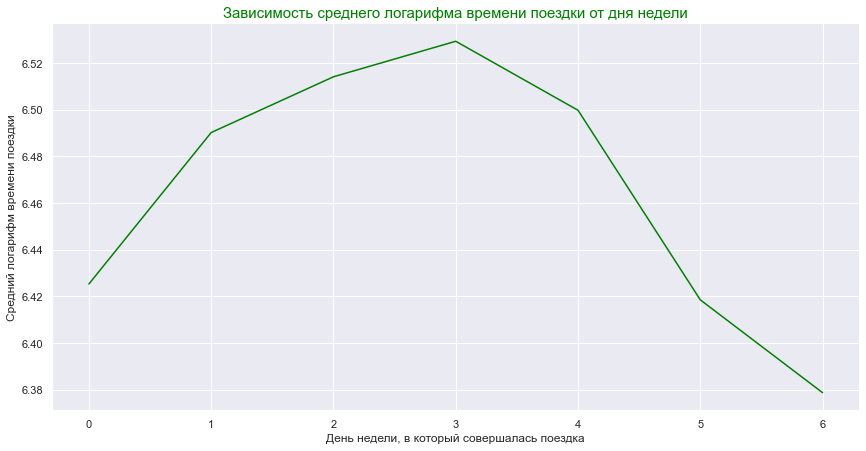

In [19]:
duration_weekday = pd.DataFrame(train_4.groupby(train_4['pickup_datetime'].dt.weekday)['log_trip_duration'].mean())
duration_weekday.reset_index(inplace=True)

sns.relplot(data=duration_weekday, y='log_trip_duration', x='pickup_datetime', kind='line', height=6, aspect=2, color='green')

plt.title('Зависимость среднего логарифма времени поездки от дня недели', color='green', fontsize = 15)
plt.xlabel('День недели, в который совершалась поездка')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

**По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от часа в сутках**

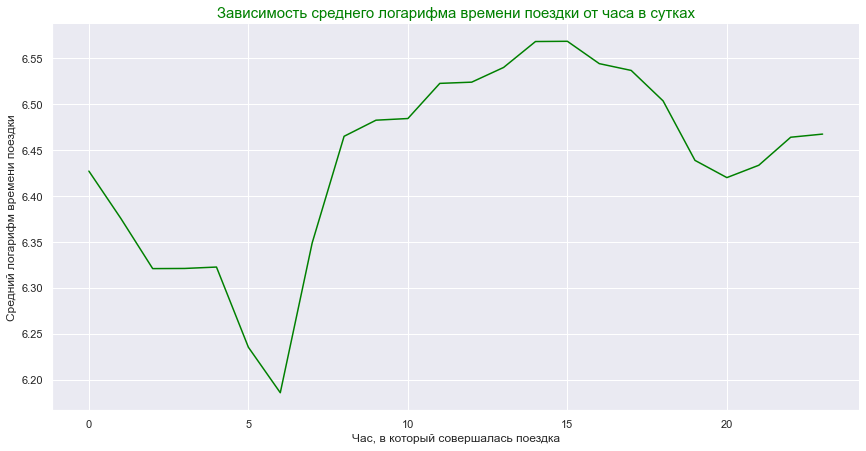

In [20]:
duration_hour = pd.DataFrame(train_4.groupby(train_4['pickup_datetime'].dt.hour)['log_trip_duration'].mean())
duration_hour.reset_index(inplace=True)

sns.relplot(data=duration_hour, y='log_trip_duration', x='pickup_datetime', kind='line', height=6, aspect=2, color='green')

plt.title('Зависимость среднего логарифма времени поездки от часа в сутках', color='green', fontsize = 15)
plt.xlabel('Час, в который совершалась поездка')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

**По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от дня в году**

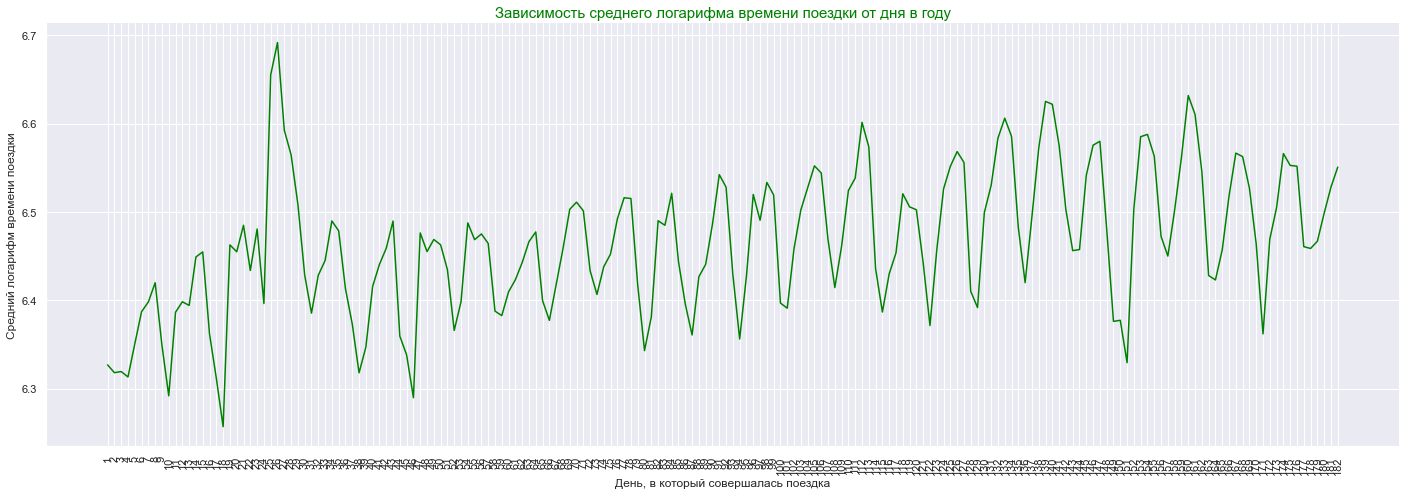

In [21]:
duration_dayofyear = pd.DataFrame(train_4.groupby(train_4['pickup_datetime'].dt.dayofyear)['log_trip_duration'].mean())
duration_dayofyear.reset_index(inplace=True)

sns.relplot(data=duration_dayofyear, y='log_trip_duration', x='pickup_datetime', kind='line', height=6.5, aspect=3, color='green')

plt.xticks(range(1, duration_dayofyear.shape[0] + 1), rotation='vertical')

plt.title('Зависимость среднего логарифма времени поездки от дня в году', color='green', fontsize = 15)
plt.xlabel('День, в который совершалась поездка')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

**<span style="color:green">Первое наблюдение:</span>**<span style="color:green"> Можно заметить, что в четверг (3й день недели) продолжительность поездок была выше, чем в другие дни. Кажется, это связано с тем, что на предыдущих графиках мы выделили четверг, как самый популярный день для поездок, следовательно загруженность дорог была выше, и значит поездка могла продлиться дольше обычного. Аналогичные выводы можно сделать и про остальные дни недели: чем выше спрос на поездки, тем поездка длиннее по времени (из-за пробок, высокой загруженности на дорогах).</span>
    
**<span style="color:green">Второе наблюдение:</span>**<span style="color:green"> Также мы видим, что похожая тенденция отражается и на графиках зависимости от часов в сутках. Графики зависимости таргета от часа в сутках и графики зависимости среднего логарифма времени поездки от часа в сутках похожи, связь аналогичная: в популярное время заказа такси, дороги более загружены, поздка длилась дольше. </span>
    
**<span style="color:green">Тренд на графике зависимости log_trip_duration от номера дня в году:</span>** <span style="color:green">Первое, что можно заметить: 23 и 24 января поездки занимали больше времени относительно других выходных дней. Более того, неделю после снежной бури продолжительность поездок резко возросла, чем в другие дни в году. Я думаю, это было связано с тем, что дороги были в снегу, их чистили, создавались пробки на дорогах. Второй, аномальный кусочек - это 151 день в году (30 мая, так как 2016 год високосный), это был понедельник, в Нью-Йорке отмечался "День поминовения". Видим, что в этот день наблюдается резкое снижение времени поездок, кажется, это было из-за того, что многие люди не пошли на работу и остались дома. Так как на следущие сутки график продолжительности поздки снова стал типичным. </span>

Добавим следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

**Добавим эти признаки в обучающую и тестовую выборку соответсвенно**

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
#день недели
train_4['weekday'] = train_4['pickup_datetime'].dt.weekday
test['weekday'] = test['pickup_datetime'].dt.weekday

#месяц
train_4['month'] = train_4['pickup_datetime'].dt.month
test['month'] = test['pickup_datetime'].dt.month

#час
train_4['hour'] = train_4['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

#номер дня в году
train_4['day_of_year'] = train_4['pickup_datetime'].dt.dayofyear
test['day_of_year'] = test['pickup_datetime'].dt.dayofyear

#аномальный период
train_4['is_snowstorm'] = ((train_4['day_of_year'] == 23) | (train_4['day_of_year'] == 24)).apply(lambda x: 1 if x else 0)
train_4['is_memorial'] = (train_4['day_of_year'] == 151).apply(lambda x: 1 if x else 0)

test['is_snowstorm'] = ((test['day_of_year'] == 23) | (test['day_of_year'] == 24)).apply(lambda x: 1 if x else 0)
test['is_memorial'] = (test['day_of_year'] == 151).apply(lambda x: 1 if x else 0)

Итак, мы уже создали некоторое количество признаков.

Определим типы признаков

**<span style="color:green">Категориальные:</span>** <span style="color:green"> Признаки, описывающие аномальные события, сделаем категириальными, так как это ограниченное множество и отсутствует линейная зависимость с целевой переменной. Тоже касается дней недели и часов в сутках.</span>

**<span style="color:green">Численные: </span>** <span style="color:green"> Номер дня в году. Думаю, что вводить 180 новых категорий не имеет смысла. И еще, модель может подстроиться именно под дни из 2016 года, а на других днях будет работать не совсем корректно. Также, мне кажется, что есть тренд на то, что с увеличением дня года растет среднее время поездки, это заметно из последнего графика. Поэтому будем считать, что линейная зависимость присутсвует.</span>

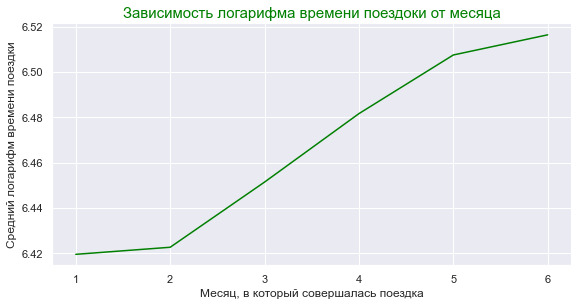

In [24]:
duration_month = pd.DataFrame(train_4.groupby(train_4['pickup_datetime'].dt.month)['log_trip_duration'].mean())
duration_month.reset_index(inplace=True)

sns.relplot(data=duration_month, y='log_trip_duration', x='pickup_datetime', kind='line',height=4, aspect=2, color='green')

plt.xticks(range(1, duration_month .shape[0] + 1))

plt.title('Зависимость логарифма времени поездоки от месяца', color = 'green', fontsize = 15 )
plt.xlabel('Месяц, в который совершалась поездка')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

<span style="color:green"> Почти присутвует) </span>

**Обучим `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируем с помощью `StandardScaler`**

### Приступим к кодированию признаков

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

**Закодируем обучающую выборку**

🛑Использем только признаки, которые мы выделили предыдущей части задания🛑

In [26]:
#Категориальные
ohe = OneHotEncoder()

catogorical_train = train_4[['is_snowstorm', 'is_memorial']].reset_index().drop('index', axis=1) #бинарные признаки, не изменяем,
                                                                                               #очистим только индексы 
#кодируем день недели. Понедельник=0,..., воскресенье = 6. 
ohe_weekday = pd.DataFrame(ohe.fit_transform(train_4[['weekday']]).toarray())
ohe_weekday.columns = map(lambda x: 'weekday_' + str(x + 1),list(ohe_weekday.columns))   #название новых столбцов вида weekday_i

#кодируем часы в сутках. 
ohe_hours = pd.DataFrame(ohe.fit_transform(train_4[['hour']]).toarray())
ohe_hours.columns = map(lambda x: 'hour_' + str(x),list(ohe_hours.columns))              #название новых столбцов вида hour_i

#соединяем то, что закодировали вместе
catogorical_train = catogorical_train.join(ohe_weekday)
catogorical_train = catogorical_train.join(ohe_hours)


#Численные
scaler = StandardScaler()
scaler = pd.DataFrame(scaler.fit_transform(train_4[['day_of_year', 'month']]))
scaler.columns = ['day_of_year', 'month']                                      

catogorical_train = catogorical_train.join(scaler)

y_train = train_4['log_trip_duration'] #целевая переменная 

Прикинем, сколько у нас должно было получиться столбцов в catogorical_train (обучающая выборка).

'is_snowstorm' и  'is_memorial' дали 2 столбца.

ohe_weekday еще 7 столбцов.

ohe_hours плюс 24  столбца.

'day_of_year', 'month' еще 2 столбца.

**ИТОГО: 2+7+24+2=35 столбцов**



In [27]:
#Верно
catogorical_train.shape[1]

35

**Закодируем тестовую выборку**

In [28]:
#Категориальные
ohe = OneHotEncoder()

catogorical_test = test[['is_snowstorm', 'is_memorial']].reset_index().drop('index', axis=1) #бинарные признаки, не изменяем,
                                                                                             #очистим только индексы 
#кодируем день недели. Понедельник=0,..., воскресенье = 6. 
ohe_weekday = pd.DataFrame(ohe.fit_transform(test[['weekday']]).toarray())
ohe_weekday.columns = map(lambda x: 'weekday_' + str(x + 1),list(ohe_weekday.columns))   #название новых столбцов вида weekday_i

#кодируем часы в сутках. 
ohe_hours = pd.DataFrame(ohe.fit_transform(test[['hour']]).toarray())
ohe_hours.columns = map(lambda x: 'hour_' + str(x),list(ohe_hours.columns))              #название новых столбцов вида hour_i

#соединяем то, что закодировали вместе
catogorical_test = catogorical_test.join(ohe_weekday)
catogorical_test = catogorical_test.join(ohe_hours)


#Численные
scaler = StandardScaler()
scaler = pd.DataFrame(scaler.fit_transform(test[['day_of_year', 'month']]))
scaler.columns = ['day_of_year', 'month']                                      

catogorical_test = catogorical_test.join(scaler)

y_test = test['log_trip_duration'] #целевая переменная 

In [29]:
catogorical_test.head()

,is_snowstorm,is_memorial,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_0,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_year,month
0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.654857,-0.901634
1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.245761,1.478117
2,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683333,0.883179
3,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.148791,0.883179
4,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.411225,-1.496571


**🛑Обучаем Ridge-регрессию с параметрами по умолчанию🛑**

In [30]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [31]:
model = Ridge()
model.fit(catogorical_train, y_train)

y_pred = model.predict(catogorical_test)
print("Train RMSE = ", mean_squared_error(y_test, y_pred, squared=False))

Train RMSE =  0.7874664092357334


Качество даже ухудшилось🙄

## Анализ координат 
Мы изучили данные о времени начала поездки, теперь посмотрим на информацию о координатах начала и конца поездки. 

<span style="color:green">По данным из независимых источников при анализекарт поездок, выделяются два аэропорта это John F. Kennedy International Airport и LaGuardia Airport </span>

Понятно, что время будет сильно зависеть от расстояния. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки.
Запишем кратчайшее расстояние для объектов в колонку `haversine`:

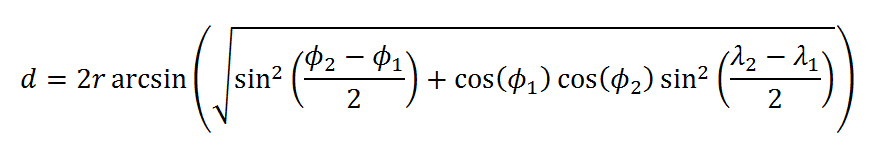

In [35]:
from IPython.display import Image
Image("haversine.png")

In [36]:
#Создадим фукнцию для подсчета кратчайшего расстояния. 
#Входные данные: широта и долгота начала и конца поездки.  

def haversine_func(lat_start, lng_start, lat_finish, lng_finish):
    
    #переведем координаты в радианы (подразумевает формула)
    lat_start, lng_start, lat_finish, lng_finish = map(np.radians, (lat_start, lng_start, lat_finish, lng_finish))
    
    #понадобится средний радиус земли, выраженный в км
    radius_earth = 6371  
    lat = lat_finish - lat_start
    lng = lng_finish - lng_start
    a = np.sin(lat * 0.5) ** 2 + np.cos(lat_start) * np.cos(lat_finish) * np.sin(lng * 0.5) ** 2
    d = 2 * radius_earth * np.arcsin(np.sqrt(a))
    return d

**Запишем кратчайшее расстояние в колонку haversine**

In [37]:
train['haversine'] = haversine_func(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                    train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,1.498521
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,1.805507
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,6.385098
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,1.485498
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,1.188588


Запишим логарифм `haversine` в отдельную колонку:

In [38]:
train['log_haversine'] = np.log1p(train['haversine'])
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,haversine,log_haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,1.498521,0.915699
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,1.805507,1.031584
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,6.385098,1.999464
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,1.485498,0.910473
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,1.188588,0.783257


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [39]:
correlation = train[['log_trip_duration', 'haversine', 'log_haversine']].corr()
correlation

,log_trip_duration,haversine,log_haversine
log_trip_duration,1.000000,0.573595,0.749882
haversine,0.573595,1.000000,0.844501
log_haversine,0.749882,0.844501,1.000000


**Посмотрим на среднюю скорость движения такси**

ВАЖНО: **trip_duration** - duration of the trip in seconds

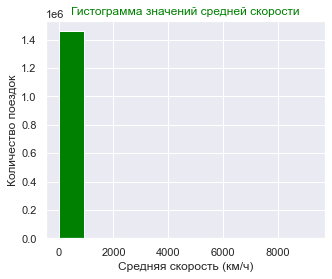

In [40]:
train['avrg_speed'] = train['haversine'] / train['trip_duration'] * 3600

plt.rcParams['figure.figsize'] = [5, 4]

plt.hist(train['avrg_speed'].values, bins=10, color = 'green')
plt.title('Гистограмма значений средней скорости', color = 'green')
plt.xlabel('Cредняя скорость (км/ч)')
plt.ylabel('Количество поездок')
plt.show()

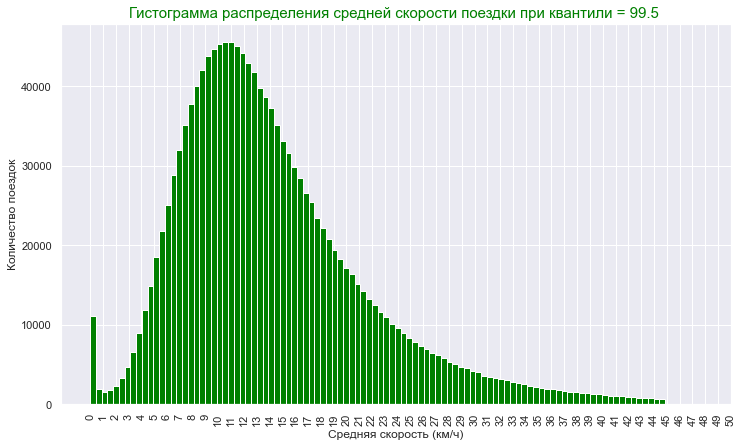

In [41]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.hist(train[train['avrg_speed'] < train['avrg_speed'].quantile(0.995)]['avrg_speed'].values, bins=100, color = 'green')

plt.title('Гистограмма распределения средней скорости поездки при квантили = 99.5 ', color='green', fontsize=15)
plt.xticks(range(51), rotation='vertical')
plt.xlabel('Cредняя скорость (км/ч)')
plt.ylabel('Количество поездок')
plt.show()

Для каждой пары (день недели, час суток) посчитаем медиану скоростей

Text(0.5, 1.0, 'Зависимость значения скорости от дня недели и часа в сутках')

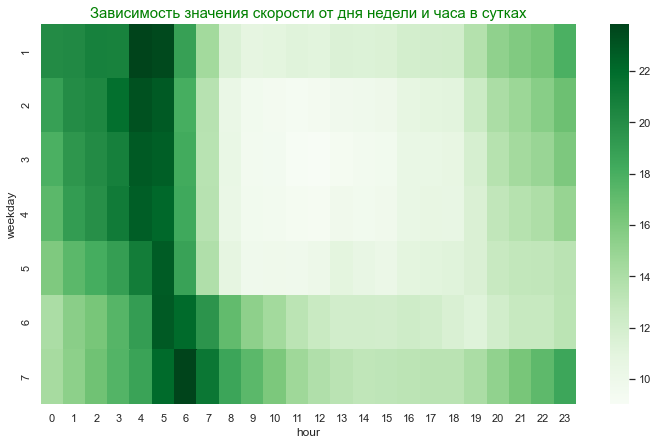

In [42]:
weekd_hour_avrspeed = pd.DataFrame(train.groupby([train['pickup_datetime'].dt.weekday,
                                                  train['pickup_datetime'].dt.hour])['avrg_speed'].median())

weekd_hour_avrspeed.index.rename(['weekday', 'hour'], inplace=True) 
weekd_hour_avrspeed.reset_index(inplace=True)

weekd_hour_avrspeed['weekday'] += 1
htmp = weekd_hour_avrspeed.pivot(index='weekday', columns='hour', values='avrg_speed')

sns.heatmap(htmp,cmap="Greens")
plt.title('Зависимость значения скорости от дня недели и часа в сутках', color = 'green', fontsize=15)

**Удалим колонку со значением средней скорости:**

In [43]:
train.drop(['avrg_speed'], axis=1, inplace=True)

**<span style="color:green">Про низкую среднюю скорость:</span>** 

<span style="color:green">Первое, что можно заметить, по будням (с понедельника по пятницу) с 7 утра до 19 вечера наблюдается самая низкая средняя скорость. Очевидно, это связано с тем, что люди едут на работу и по делам, дороги загружены. </span>

<span style="color:green">В субботу, самая низкая скорость наблюдается с 12 дня до 23 вечера, наверное, люди позже просыпаются и едут в магазины или на дачу в это время. </span>

<span style="color:green">Воскресенье выделяется, потому что в этот день скорость выше, чем в остальные дни. Кусочек с 13 до 19 - средняя скорость ниже.</span>

**<span style="color:green">Про высокую среднюю скорость:</span>**

<span style="color:green">В будние дни средняя скорость выше в ночное время (до 6 утра), при чем самая выскоая средняя скорость где-то в 4-5 утра. Люди спят, дороги свободные. </span>

<span style="color:green">По выходным это период с 4 до 8 утра. По аналогичным причинам.</span>

<span style="color:green">Если обратить внимание на движение в вечернее время, то заметно, что 23 часа в воскресенье и понедельник выделяются от 23 часов в другие дни недели. Именно в эти два дня в 23 часа средняя скорость выше. В воскресенье это можно объяснить тем, что люди пораньше хотят вернуться домой, чтобы приготовиться к рабочей неделе. А вот в понедельник вопрос... Возможно устали от первого рабочего дня и не хотят никуда уезжать ночью...</span>

**Очень важно учитывать загруженность на дорогах во время поездки, особенно если речь идет о крупных мегаполисах**

Создаим признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (они не будут зависеть от скорости)

In [44]:
#Загруженные дороги по будням (пн=0,...,пт=4)
weekdays_traffic_jam = (train['pickup_datetime'].dt.weekday <= 4) & \
                       (train['pickup_datetime'].dt.hour >= 7) & \
                       (train['pickup_datetime'].dt.hour <= 19)

#Пробки в субботу (сб=5)
sat_traffic_jam = (train['pickup_datetime'].dt.weekday == 5) & \
                  (train['pickup_datetime'].dt.hour >= 12) & \
                  (train['pickup_datetime'].dt.hour <= 23) 

#Пробки в воскресенье (вс=6)    
sun_traffic_jam = (train['pickup_datetime'].dt.weekday == 6) & \
                  (train['pickup_datetime'].dt.hour >= 13) & \
                  (train['pickup_datetime'].dt.hour <= 19) 

#Признак - "поездка совершается в период пробок"
train['is_jam'] = (weekdays_traffic_jam | sat_traffic_jam | sun_traffic_jam).apply(lambda x: 1 if x else 0)


#Свободные дороги по будням
weekdays_traffic_free = (train['pickup_datetime'].dt.weekday <= 4) & \
                  (train['pickup_datetime'].dt.hour <= 6)

#Свободные дороги в выходные
weekends_traffic_free = (train['pickup_datetime'].dt.weekday >= 5) & \
                        (train['pickup_datetime'].dt.hour >= 4) & \
                        (train['pickup_datetime'].dt.hour <= 8)

#те самые 23 часа в понедельник (пн=0) и воскресенье (вс=6)
mon_sun_free = ((train['pickup_datetime'].dt.weekday == 0) | (train['pickup_datetime'].dt.weekday == 6)) & \
               ((train['pickup_datetime'].dt.hour == 23))

#Признак - "поездка совершается в период свободных дорог"
train['is_free'] = (weekdays_traffic_free | weekends_traffic_free | mon_sun_free).apply(lambda x: 1 if x else 0)

In [45]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,haversine,log_haversine,is_jam,is_free
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,1.498521,0.915699,1,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,1.805507,1.031584,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,6.385098,1.999464,1,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,1.485498,0.910473,1,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,1.188588,0.783257,1,0


<span style="color:green">Мы выделили две точки - два аэропорта это John F. Kennedy International Airport и LaGuardia Airport.</span>

In [46]:
#Терминал аэропорта Кеннеди 40.666056,-73.812310  
#Конец терминала аэропорта 40.644558, -73.777260
train['pickup_kennedy'] = ((train['pickup_latitude'] <= 40.666056) \
                        & (train['pickup_latitude'] >= 40.644558) \
                        & (train['pickup_longitude'] >= -73.812310) \
                        & (train['pickup_longitude'] <= -73.777260)).apply(lambda x: 1 if x else 0)

train['dropoff_kennedy'] = ((train['dropoff_latitude'] <= 40.666056) \
                         & (train['dropoff_latitude'] >= 40.644558) \
                         & (train['dropoff_longitude'] >= -73.812310) \
                         & (train['dropoff_longitude'] <= -73.777260)).apply(lambda x: 1 if x else 0)


#Терминал аэропорта ЛаГурдия 40.776941,-73.873965
#Терминал прибытия аэропорта ЛаГурдия 40.772754,-73.871829
train['pickup_laguardia'] = ((train['pickup_latitude'] <= 40.776941) \
                          & (train['pickup_latitude'] >= 40.772754) \
                          & (train['pickup_longitude'] >= -73.873965) \
                          & (train['pickup_longitude'] <= -73.871829)).apply(lambda x: 1 if x else 0)

train['dropoff_laguardia'] = ((train['dropoff_latitude'] <= 40.776941) \
                           & (train['dropoff_latitude'] >= 40.772754) \
                           & (train['dropoff_longitude'] >= -73.873965) \
                           & (train['dropoff_longitude'] <= -73.871829)).apply(lambda x: 1 if x else 0)

Text(0.5, 1.0, 'Зависимость значения продолжительности поездки и загруженных дорог')

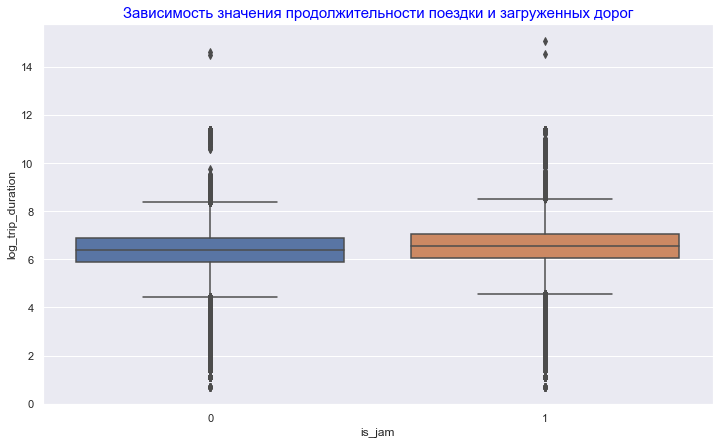

In [47]:
sns.boxplot(x = 'is_jam', y = 'log_trip_duration', data = train)
plt.title('Зависимость значения продолжительности поездки и загруженных дорог', color = 'blue', fontsize=15)

Text(0.5, 1.0, 'Зависимость значения продолжительности поездки и свободных дорог')

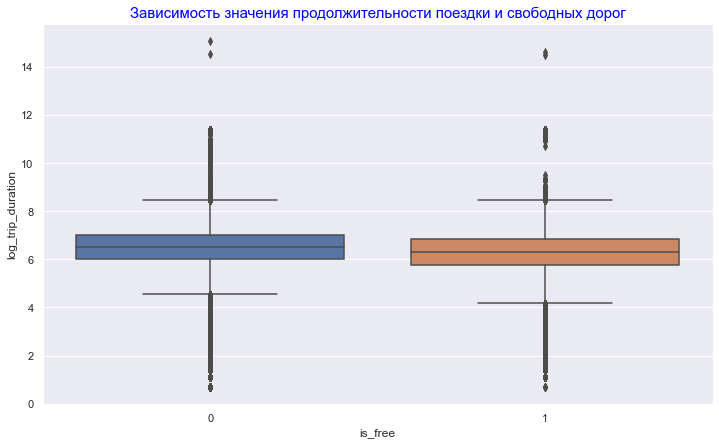

In [48]:
sns.boxplot(x = "is_free", y = "log_trip_duration", data = train)
plt.title('Зависимость значения продолжительности поездки и свободных дорог', color = 'blue', fontsize=15)

Text(0.5, 1.0, 'Зависимость значения продолжительности поездки и поездки в или из аэропорта Кеннеди')

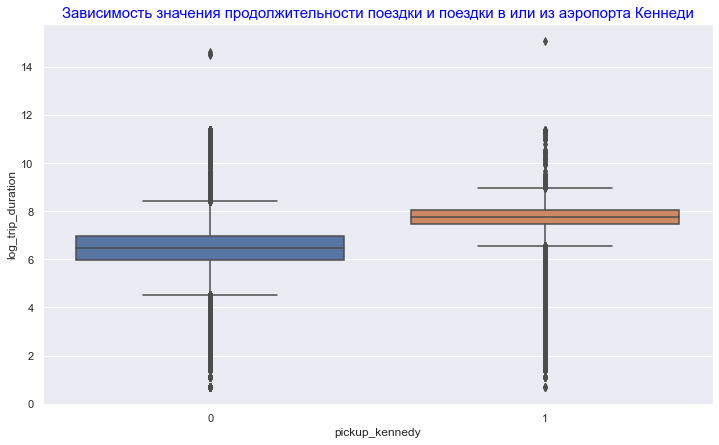

In [49]:
sns.boxplot(x = "pickup_kennedy", y = "log_trip_duration", data = train)
plt.title('Зависимость значения продолжительности поездки и поездки в или из аэропорта Кеннеди', color = 'blue', fontsize=15)

Text(0.5, 1.0, 'Зависимость значения продолжительности поездки и поездки в или из аэропорта ЛаГуардия')

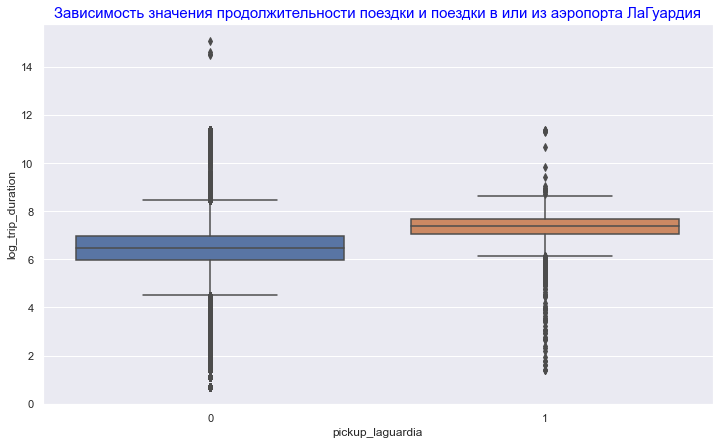

In [50]:
sns.boxplot(x = "pickup_laguardia", y = "log_trip_duration", data = train)
plt.title('Зависимость значения продолжительности поездки и поездки в или из аэропорта ЛаГуардия', color = 'blue', fontsize=15)

**<span style="color:green">Можно отметить, что признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" получились правильными, однако признаки, связанные с двумя аэропортами получились более сильными.</span>**

Обучим `Ridge`-регрессию на признаках, которые мы выделили к текущему моменту. 

**Смотрим на типы признаков:**

<span style="color:green">Разберемся, какие признаки относятся к категориальным: на мой взгляд, сектор где началась и закончилась поездка было бы разумно сделать категориальными признаками, так как нет зависимости с целевой переменной. Соотвественно, как в предыдущем задании день недели и часы в сутках тоже будут категориальными. </span>

<span style="color:green">Численные: день в году, месяц и расстояние. Выяснили, что у этих признаков линейная зависимость с целевой переменной присутвует. </span>

<span style="color:green">Оставшиеся признаки мы просто добавим. </span>

In [56]:
category = ['weekday', 'hour', 'pickup_sector', 'dropoff_sector']
numer = ['log_haversine', 'day_of_year', 'month']
other = ['is_jam', 'is_free', 'pickup_kennedy', 'dropoff_kennedy',
         'pickup_laguardia', 'dropoff_laguardia', 'is_snowstorm','is_snowstorm']

In [57]:
from sklearn.pipeline import Pipeline

In [58]:
#сформируем единое пространство кодирующих функций с помощью ColumnTransformer
date_tr = ColumnTransformer([
                     ('ohe', OneHotEncoder(handle_unknown="ignore"), category),
                     ('scaler', StandardScaler(), numer),
                     ('add',  'passthrough', other)
                     ])

#создадим пайплайн с Ridge регрессией и кодировщиком данных 
pipeline = Pipeline(steps=[
                   ('ohe_and_st_scaler', date_tr),
                   ('regression', Ridge())
                   ])

Переходим к обучению

In [59]:
#разобьем X2 на трейн и тест в отношении 7:3
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, train['log_trip_duration'], test_size=0.3, random_state=1)

In [60]:
model = pipeline.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)
print("Test RMSE = ", mean_squared_error(y2_test, y_pred, squared=False))

Test RMSE =  0.489195161495137


**Качество модели заметно возросло)**

### Поработаем над улучшением модели

**Посмотрим на аномалии во временах поездки:**

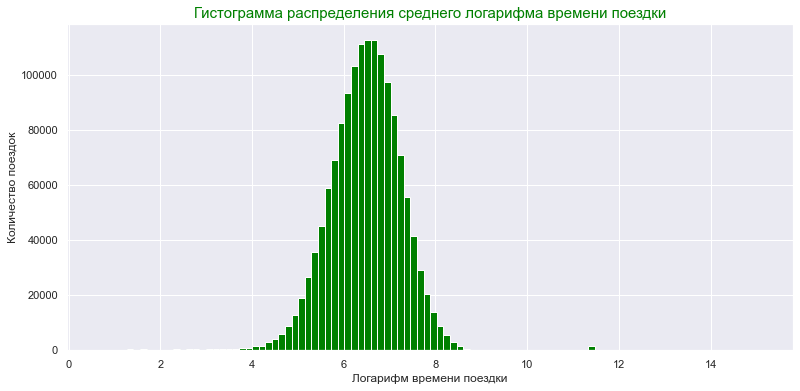

In [72]:
plt.rcParams['figure.figsize'] = [13,6]
plt.hist(train.log_trip_duration.values, bins=100, color = 'green')
plt.title('Гистограмма распределения среднего логарифма времени поездки', color = 'green', fontsize = 15)
plt.ylabel('Количество поездок')
plt.xlabel('Логарифм времени поездки')
plt.show()

**Вывод:** поездки, которые длились меньше минуты нужно отбросить, так как скорее всего это ошибочные поездки, так как время в пути супер маленькое. Соответственно, средний логарифм таких поездок должен быть меньше четырех. 

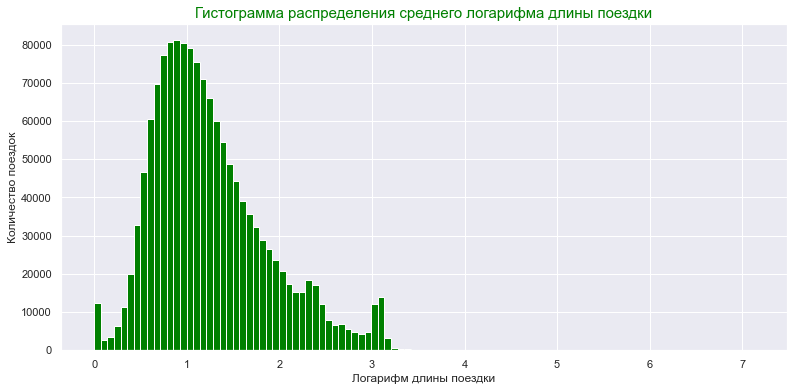

In [73]:
plt.hist(train.log_haversine.values, bins=100, color = 'green')
plt.title('Гистограмма распределения среднего логарифма длины поездки', color = 'green', fontsize = 15)
plt.xlabel('Логарифм длины поездки')
plt.ylabel('Количество поездок')
plt.show()

**Вывод:** будем говорить, про большие пройденные расстояния. Давайте считать, что если пройдено больше 40 км, то это выброс и его нужно чистить. (3,6 равен средний логарифм в данном случае)

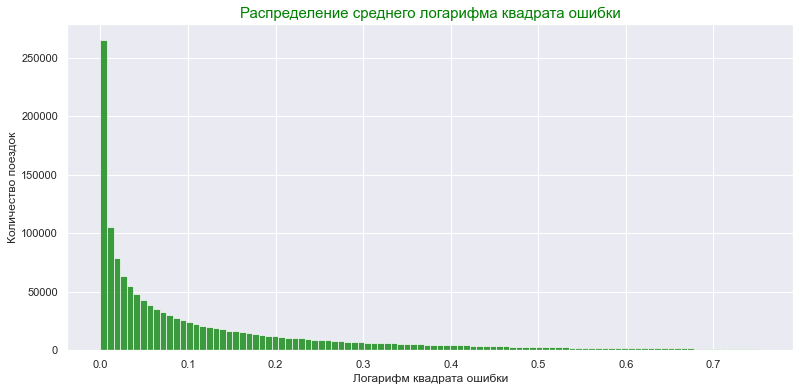

In [76]:
#посмотрим на остатки регрессии
reg_res = (train['log_trip_duration'] - pipeline.predict(X2)) ** 2

#ограничение - квантиль 95%
sns.histplot(reg_res[reg_res < reg_res.quantile(0.95)], bins=100, color = 'green')

plt.title('Распределение среднего логарифма квадрата ошибки', color = 'green', fontsize = 15)
plt.xlabel('Логарифм квадрата ошибки')
plt.ylabel('Количество поездок')
plt.show()

**Чистим наши данные от выбросов:**

In [77]:
X2_new = X2[(train['log_trip_duration'] > 4) & (train['log_haversine'] < 3.6) & (reg_res < reg_res.quantile(0.95))]

y2_new = train[(train['log_trip_duration'] > 4) & (train['log_haversine'] < 3.6) & 
               (reg_res < reg_res.quantile(0.95))]['log_trip_duration']

**Обучаем и тестируем:**

In [78]:
model = pipeline.fit(X2_new, y2_new)

y_pred = model.predict(X2_test)

print("Train RMSE = " , mean_squared_error(y2_test, y_pred, squared=False))

C:\Users\krup1\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Train RMSE =  0.49049867589580753


Изменения в лучшую сторону, но совсем незначительные(

Можно заметить, что сейчас в данных есть проблема - много категориальных признаков. Часто там могут содержаться редкие категори, и модель может переобучиться на таких примерах. Поработаем над этим: объединим редкие категории.

In [79]:
import scipy

In [80]:
#данные со всеми категориями, отмасштабированные
data_coded = date_tr.fit_transform(X2_new)

#создаем с этими данными датафрейм 
X2_special_cat = pd.DataFrame.sparse.from_spmatrix(data_coded)

#поменяем названия столбцов на нормальные 
X2_special_cat.columns = list(date_tr.named_transformers_['ohe'].get_feature_names()) + numer + other

In [81]:
X2_special_cat.head()

,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x1_0,x1_1,x1_2,...,day_of_year,month,is_jam,is_free,pickup_kennedy,dropoff_kennedy,pickup_laguardia,dropoff_laguardia,is_snowstorm,is_snowstorm
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.343189,-0.304769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.403378,1.481234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.410536,-1.495438,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103156,0.290565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.110314,-0.304769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
X2_special_cat.shape

(1385490, 84)

Теперь посмотрим на то, сколько в каждом из столбцов, полученных с помощью ohe, единичек. По сути мы будем смотреть на, как встречается каждая из категорий. 

In [83]:
amount_of_category = []

for col in list(date_tr.named_transformers_['ohe'].get_feature_names()):
    cat = X2_special_cat[X2_special_cat[col]==1].count().values[0]
    
    amount_of_category.append([cat, col])

In [84]:
amount_of_category.sort()
amount_of_category

[[6112, 'x3_1'],
 [6524, 'x3_4'],
 [6861, 'x2_5'],
 [6961, 'x2_11'],
 [7119, 'x2_1'],
 [7323, 'x3_13'],
 [7368, 'x3_2'],
 [7406, 'x3_5'],
 [7608, 'x3_11'],
 [7716, 'x2_4'],
 [7734, 'x3_17'],
 [7934, 'x3_9'],
 [8010, 'x3_18'],
 [8294, 'x2_17'],
 [8311, 'x3_8'],
 [8669, 'x3_19'],
 [8901, 'x3_12'],
 [8976, 'x2_2'],
 [9127, 'x3_10'],
 [9356, 'x3_3'],
 [9370, 'x3_6'],
 [9407, 'x3_7'],
 [9679, 'x2_19'],
 [9811, 'x3_14'],
 [10056, 'x2_8'],
 [10270, 'x3_20'],
 [10333, 'x2_6'],
 [10404, 'x2_13'],
 [10699, 'x2_12'],
 [10775, 'x2_18'],
 [11229, 'x2_10'],
 [11467, 'x3_15'],
 [11482, 'x2_14'],
 [11606, 'x2_3'],
 [11665, 'x2_9'],
 [11705, 'x2_20'],
 [13775, 'x3_16'],
 [14117, 'x2_7'],
 [14459, 'x1_5'],
 [15001, 'x1_4'],
 [15793, 'x2_15'],
 [17957, 'x2_16'],
 [20038, 'x1_3'],
 [26856, 'x1_2'],
 [32232, 'x1_6'],
 [37017, 'x1_1'],
 [51004, 'x1_0'],
 [53066, 'x1_7'],
 [60453, 'x1_16'],
 [61589, 'x1_10'],
 [63630, 'x1_9'],
 [63687, 'x1_8'],
 [64474, 'x1_11'],
 [66865, 'x1_13'],
 [66969, 'x1_23'],
 [67189

Будем считать колонку редкой, если в ней единиц меньше 10 000.

In [85]:
rare_сol = ['x3_1','x3_4','x2_5','x2_11','x2_1','x3_13','x3_2','x3_5','x3_11','x2_4','x3_17','x3_9','x3_18','x2_17','x3_8',
            'x3_19','x3_12','x2_2','x3_10','x3_3','x3_6','x3_7','x2_19','x3_14']

**Объединим колонки с редкими категориями:**

In [86]:
rares_column = pd.DataFrame(np.where((X2_special_cat['x3_1'] == 1) | (X2_special_cat['x3_4'] == 1) | 
                            (X2_special_cat['x2_5'] == 1)  | (X2_special_cat['x2_11'] == 1) |
                            (X2_special_cat['x2_1'] == 1)  | (X2_special_cat['x3_13'] == 1) |
                            (X2_special_cat['x3_2'] == 1)  | (X2_special_cat['x3_5'] == 1) |
                            (X2_special_cat['x3_11'] == 1) | (X2_special_cat['x2_4'] == 1) |
                            (X2_special_cat['x3_17'] == 1) | (X2_special_cat['x3_9'] == 1) |
                            (X2_special_cat['x3_18'] == 1) | (X2_special_cat['x2_17'] == 1)|
                            (X2_special_cat['x3_8'] == 1)  | (X2_special_cat['x3_19'] == 1)|
                            (X2_special_cat['x3_12'] == 1) | (X2_special_cat['x2_2'] == 1)| 
                            (X2_special_cat['x3_10'] == 1) | (X2_special_cat['x3_3'] == 1)| 
                            (X2_special_cat['x3_6'] == 1)  | (X2_special_cat['x3_7'] == 1)|
                            (X2_special_cat['x2_19'] == 1) | (X2_special_cat['x3_14'] == 1),
                            1, 0))

**Избавимся от колонок редких категорий:**

In [87]:
X2_special_cat = X2_special_cat.drop(rare_сol, axis=1)

**Добавим объединенные редкие категории:**

In [88]:
X2_special_cat['rares_column'] = rares_column

In [89]:
X2_special_cat.columns

Index(['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x1_0', 'x1_1',
       'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x1_6', 'x1_7', 'x1_8', 'x1_9', 'x1_10',
       'x1_11', 'x1_12', 'x1_13', 'x1_14', 'x1_15', 'x1_16', 'x1_17', 'x1_18',
       'x1_19', 'x1_20', 'x1_21', 'x1_22', 'x1_23', 'x2_-1', 'x2_3', 'x2_6',
       'x2_7', 'x2_8', 'x2_9', 'x2_10', 'x2_12', 'x2_13', 'x2_14', 'x2_15',
       'x2_16', 'x2_18', 'x2_20', 'x3_-1', 'x3_15', 'x3_16', 'x3_20',
       'log_haversine', 'day_of_year', 'month', 'is_jam', 'is_free',
       'pickup_kennedy', 'dropoff_kennedy', 'pickup_laguardia',
       'dropoff_laguardia', 'is_snowstorm', 'is_snowstorm', 'rares_column'],
      dtype='object')

**Обучаем и тестируем:**

In [90]:
ridge = Ridge()

X3_train, X3_test, y3_train, y3_test = train_test_split(X2_special_cat, y2_new, test_size=0.3, random_state=10)
ridge.fit(X3_train, y3_train)

y_pred = ridge.predict(X3_test)
print("Train RMSE = ", mean_squared_error(y3_test, y_pred, squared=False))

C:\Users\krup1\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\krup1\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Train RMSE =  0.35286625531716115


Заметное улучшение качества :-)